In [1]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.network_builder import NetworkBuilder
from hnn_core.cell import _get_gaussian_connection
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import utils
import multiprocessing
device = torch.device("cuda:0")
num_cores = multiprocessing.cpu_count()
torch.backends.cudnn.enabled = True

In [2]:

def add_noise(net, rate=50, weight=0.1, rng_seed=0):
    # Initialize random number generator for integers
    rng = np.random.default_rng(rng_seed)
    seed_array = rng.integers(0, 1000000, size=1000)

    # Add Poisson drives
    weights_ampa_d1 = {'L2_pyramidal': weight, 'L5_pyramidal': weight,
                       'L2_basket': weight}
    rates_d1 = {'L2_pyramidal': rate, 'L5_pyramidal': rate, 'L2_basket': rate}

    net.add_poisson_drive(
        name='distal', tstart=0, tstop=None, rate_constant=rates_d1, location='distal', n_drive_cells='n_cells',
        cell_specific=True, weights_ampa=weights_ampa_d1, weights_nmda=None, space_constant=1e50,
        synaptic_delays=0.0, probability=1.0, event_seed=seed_array[0], conn_seed=seed_array[1])

    weights_ampa_p1 = {'L2_pyramidal': weight, 'L5_pyramidal': weight,
                       'L2_basket': weight, 'L5_basket': weight}
    rates_p1 = {'L2_pyramidal': rate, 'L5_pyramidal': rate, 'L2_basket': rate, 'L5_basket': rate}

    net.add_poisson_drive(
        name='proximal', tstart=0, tstop=None, rate_constant=rates_p1, location='proximal', n_drive_cells='n_cells',
        cell_specific=True, weights_ampa=weights_ampa_p1, weights_nmda=None, space_constant=1e50,
        synaptic_delays=0.0, probability=1.0, event_seed=seed_array[2], conn_seed=seed_array[3])

In [3]:
%%capture
hnn_core_root = op.dirname(hnn_core.__file__)
params_fname = op.join(hnn_core_root, 'param', 'default.json')
params = read_params(params_fname)
params.update({'N_pyr_x': 3, 'N_pyr_y': 3})
net_train = calcium_model(params)
# net_validation = net_train.copy()
add_noise(net_train, rng_seed=10)
# add_noise(net_validation, rng_seed=1)


dt = 0.5
dpl_train = simulate_dipole(net_train, dt=dt, tstop=2000, record_vsec='all', record_isec='all')
# dpl_validation = simulate_dipole(net_validation, dt=dt, tstop=1000, record_vsec='all', record_isec='all')

In [4]:
dataset_cell_type = 'L5_pyramidal'
training_set = utils.CellType_Dataset_Fast(net_train, cell_type=dataset_cell_type, window_size=500, data_step_size=500, device='cpu')

In [5]:
#LSTM/GRU architecture for decoding
class model_lstm(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim=64, n_layers=5, dropout=0.1, kernel_size=200, device='cuda:0', bidirectional=False):
        super(model_lstm, self).__init__()

        #multiplier based on bidirectional parameter
        if bidirectional:
            num_directions = 2
        else:
            num_directions = 1

        # Defining some parameters
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers * num_directions
        self.device = device
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.kernel_size = kernel_size

        self.tau1, self.tau2 = 10, 20
        self.kernel = self.get_kernel(torch.arange(0, kernel_size, 1),
                                      tau1=self.tau1, tau2=self.tau2).float().to(self.device).flip(0)

        # LSTM Layer
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)   

        self.fc_input = nn.Sequential(
            nn.Linear(input_size, self.hidden_dim),
            nn.Tanh(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Tanh()
        )

        self.fc_output = nn.Sequential(
            nn.Tanh(),
            nn.Linear(hidden_dim*num_directions, self.hidden_dim),
            nn.Tanh(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Linear(self.hidden_dim, self.output_size)

        )
    
    def forward(self, x, hidden):
        batch_size = x.size(0)
    
        kernel_product = self.kernel.tile(dims=(batch_size, self.input_size, 1)).transpose(1,2)

        out = (kernel_product * x).sum(dim=1).unsqueeze(1)
        # print(out.shape)

        out = self.fc_input(out.contiguous())
        out, hidden = self.lstm(out, hidden)
        out = out.contiguous()
        out = self.fc_output(out)
            
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        weight = next(self.parameters()).data.to(self.device)

        # LSTM cell initialization
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device))
    
        return hidden

    def get_kernel(self, t_vec, tau1=10, tau2=20):
        G = tau2/(tau2-tau1)*(-torch.exp(-t_vec/tau1) + torch.exp(-t_vec/tau2))
        return G

In [6]:
L5pyr_model = model_lstm(input_size=training_set[0][0].shape[1], output_size=training_set[0][1].shape[1], device=device).to(device)
L5pyr_model.load_state_dict(torch.load('L5_pyramidal_model.pt'))

<All keys matched successfully>

In [32]:
# def run_model(model, validation_set):
#     val_data = validation_set[:][0][:,:,:].float().to(device)
#     with torch.no_grad():
#         model.eval()
#         output_sequence = []
#         hidden = model.init_hidden(val_data.size(0))
#         for t in range(model.kernel_size, val_data.size(1)):
#             output, hidden = model(val_data[:,(t-model.kernel_size):t, :], hidden)
#             output_sequence.append(output)

#         output_sequence = torch.cat(output_sequence, dim=1)

#     return output_sequence


In [33]:
def get_drive_indices(drive_name, receptor, training_set, net):
    if drive_name == 'soma':
        drive_loc = ['soma']
    else:
        drive_loc = net.cell_types['L5_pyramidal'].sect_loc[drive_name]
    syn_names = [f'{loc}_{receptor}' for loc in drive_loc]
    syn_indices = np.where(np.in1d(training_set.isec_names, syn_names))[0]

    return syn_indices
    


In [11]:
n_L5Pyr = 100
n_inhib = 30
# n_inhib = 0

L5pyr_gids = list(range(0,n_L5Pyr))
inhib_gids = list(range(n_L5Pyr, n_L5Pyr+n_inhib))

n_cells = n_L5Pyr + n_inhib

n_samples = 5000
input_spikes = np.zeros((n_cells, n_samples, len(training_set.isec_names)))

prox_indices = get_drive_indices('proximal', 'ampa', training_set, net_train)
inhib_indices = get_drive_indices('soma', 'gabaa', training_set, net_train)

# prox_time_indices = np.arange(0, n_samples, 1000)  # 1 Hz input

drive_target_gids = np.random.choice(L5pyr_gids, size=30, replace=False)
for gid in drive_target_gids:
    prox_time_indices = np.random.choice(list(range(0, n_samples)), size=100, replace=False)
    drive_weight = np.random.uniform(0, 10)
    for isec_idx in prox_indices:
        input_spikes[gid, prox_time_indices, isec_idx] = drive_weight
     


In [13]:
# 

Text(0, 0.5, 'Target Cell')

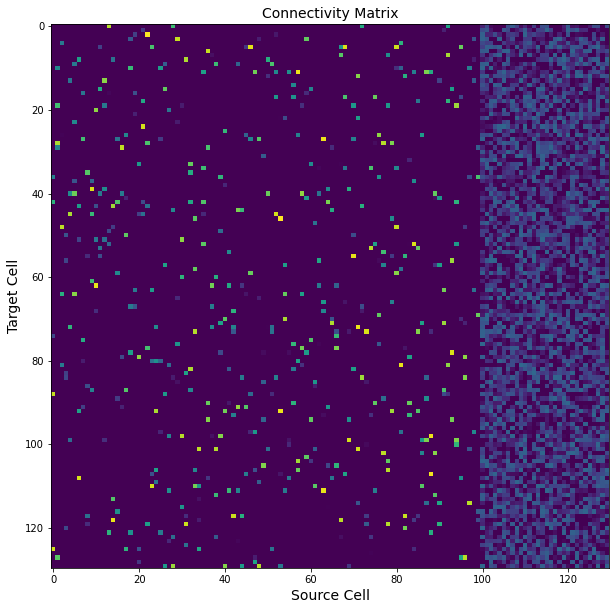

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(weight_matrix.sum(axis=1), aspect='auto')
plt.title('Connectivity Matrix', fontsize=14)
plt.xlabel('Source Cell', fontsize=14)
plt.ylabel('Target Cell', fontsize=14)

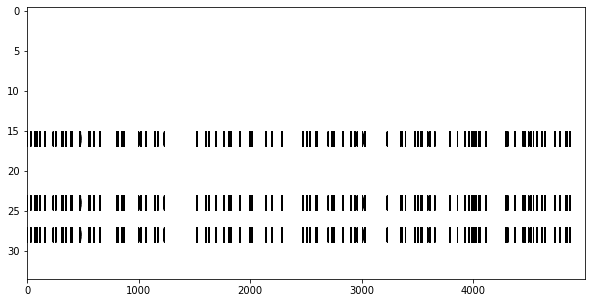

In [15]:
plt.figure(figsize=(10, 5))
plt.imshow(input_spikes[drive_target_gids[0],:,:].T, aspect='auto', cmap='gray_r', vmin=0, vmax=0.0005)

In [20]:
# weight_tensor = torch.from_numpy(weight_matrix).clone().detach().to(device).requires_grad_(True)
weight_param = nn.ParameterList([weight_matrix.clone()]).to(device)

lr = 1
weight_decay = 0
max_epochs = 1000
optimizer = torch.optim.Adam(weight_param, lr=lr, weight_decay=weight_decay)


In [ ]:
#LSTM/GRU architecture for decoding
class model_network(nn.Module):
    def __init__(self, L5Pyr_model, soma_idx, device='cuda:0', bidirectional=False):
        super(model_network, self).__init__()
        self.L5Pyr_model = L5Pyr_model
        self.threshold = 3.0
        self.soma_idx = soma_idx  # index of soma compartment

        weight_matrix = self.init_weight_matrix(n_cells=n_cells, n_sec=L5pyr_model.input_size, sec_indices=prox_indices,
                                     src_size=n_L5Pyr, target_size=5, src_range=L5pyr_gids)
                                     
        weight_matrix = self.init_weight_matrix(n_cells=n_cells, n_sec=L5pyr_model.input_size, sec_indices=inhib_indices,
                                            src_size=n_inhib, target_size=100, src_range=inhib_gids, weight_matrix=weight_matrix)

        self.weight_param = nn.ParameterList([weight_matrix]).to(device)

    def forward(self, input_spikes_tensor):
        pred_y = list()
        hidden = self.L5pyr_model.init_hidden(input_spikes_tensor.size(0))
        for time_idx in range(self.L5pyr_model.kernel_size, 1000):
            batch_x = input_spikes_tensor[:, time_idx-self.L5pyr_model.kernel_size:time_idx, :].to(device)

            out, hidden = self.L5pyr_model(batch_x, hidden)
            pred_y.append(out[:,-1, self.soma_idx])

            if time_idx > self.L5pyr_model.kernel_size:
                spike_mask = ((pred_y[-1][:] > self.threshold) & (pred_y[-2][:] < self.threshold))
            
                input_spikes_tensor[:, time_idx+1, :] += torch.matmul(weight_param[0], spike_mask.float())

        pred_y = torch.stack(pred_y)

    def init_weight_matrix(self, n_cells, n_sec, sec_indices, src_size=100, target_size=100,
                           src_range=None, target_range=None, max_weight=10, weight_matrix=None):
        if weight_matrix is None:
            weight_matrix = torch.zeros((n_cells, n_sec, n_cells)).float()
        
        if src_range is None:
            src_range = list(range(n_cells))

        if target_range is None:
            target_range = list(range(n_cells))

        src_gid_list = np.random.choice(src_range, size=src_size, replace=False)
        for src_gid in src_gid_list:
            target_gid_list = np.random.choice(target_range, size=target_size, replace=False)
            for target_gid in target_gid_list:
                # print(weight_matrix)
                weight_matrix[target_gid, sec_indices, src_gid] += np.random.uniform(0,max_weight)
        return weight_matrix

In [21]:
threshold = 3.0


for epoch in range(100):
    L5pyr_model.train()
    optimizer.zero_grad()
    input_spikes_tensor = torch.tensor(input_spikes).float().to(device).requires_grad_(False)
    pred_y = list()
    hidden = L5pyr_model.init_hidden(input_spikes_tensor.size(0))
    for time_idx in range(L5pyr_model.kernel_size, 1000):
        batch_x = input_spikes_tensor[:, time_idx-L5pyr_model.kernel_size:time_idx, :].to(device)

        out, hidden = L5pyr_model(batch_x, hidden)
        pred_y.append(out[:,-1,-1])

        if time_idx > L5pyr_model.kernel_size:
            spike_mask = ((pred_y[-1][:] > threshold) & (pred_y[-2][:] < threshold))
        
            input_spikes_tensor[:, time_idx+1, :] += torch.matmul(weight_param[0], spike_mask.float())

    pred_y = torch.stack(pred_y)

    avg_soma = torch.mean(pred_y, axis=1)
    out_fft = torch.fft.rfft(avg_soma).abs()
    freq = torch.fft.rfftfreq(pred_y.size(0), dt / 1e3)

    beta_power = torch.sum(out_fft[torch.logical_and(freq > 15, freq < 30)])
    total_power = torch.sum(out_fft[torch.logical_and(freq > 1, freq < 100)])

    relative_beta_power = - (beta_power / total_power)

    relative_beta_power.backward()
    optimizer.step()
    print(relative_beta_power.item(), end=' ')


-0.22395263612270355 -0.1788496971130371 -0.22770653665065765 -0.21187154948711395 -0.1173175722360611 -0.1449662446975708 -0.10234805941581726 -0.17999856173992157 -0.21335533261299133 -0.22236979007720947 -0.2257463037967682 -0.17846383154392242 -0.22506603598594666 -0.22514665126800537 -0.21929995715618134 -0.26643750071525574 -0.27369827032089233 -0.27713748812675476 -0.26397913694381714 -0.28616592288017273 -0.2393062263727188 -0.2991262376308441 -0.29683780670166016 -0.2084265500307083 -0.3132862150669098 -0.29361528158187866 -0.3153562545776367 -0.27677997946739197 -0.29016318917274475 -0.3255372941493988 -0.29369574785232544 -0.26430806517601013 -0.28248172998428345 -0.25409048795700073 -0.3005906939506531 -0.31557196378707886 -0.3129669427871704 -0.2918006181716919 -0.27647170424461365 -0.34760817885398865 -0.35938894748687744 -0.37661731243133545 -0.2904795706272125 -0.3261769115924835 -0.31669774651527405 -0.2725265920162201 -0.38249942660331726 -0.28316447138786316 -0.28654

KeyboardInterrupt: 

(-1.0, 100.0)

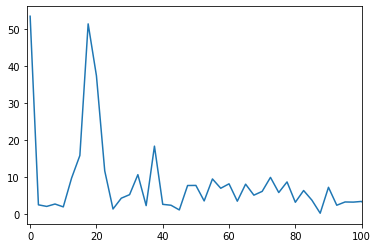

In [22]:
plt.plot(freq.detach().cpu().numpy(), out_fft.detach().cpu().numpy())
plt.xlim(-1, 100)

Text(0, 0.5, 'Target Cell')

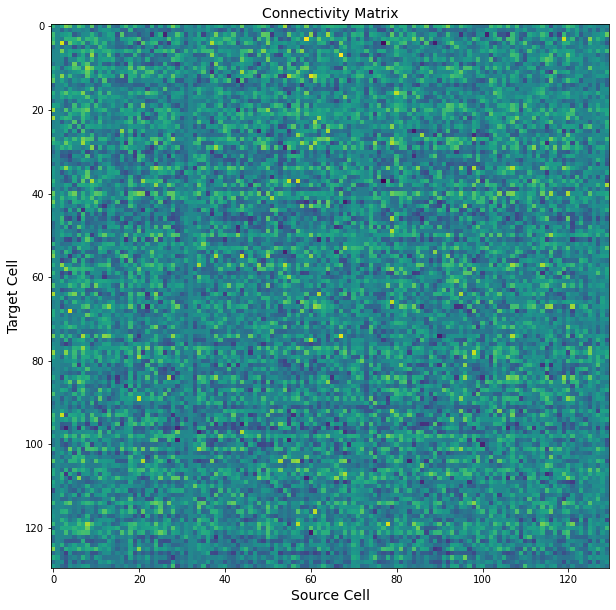

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(weight_param[0].detach().cpu().numpy().sum(axis=1), aspect='auto')
plt.title('Connectivity Matrix', fontsize=14)
plt.xlabel('Source Cell', fontsize=14)
plt.ylabel('Target Cell', fontsize=14)

In [23]:
def run_simulation_eval(model, input_spikes, weight_matrix, threshold=4.0):
    threshold = 4.0
    weight_tensor = weight_matrix.float().to(device)
    cell_spiked = torch.zeros((n_cells,)).to(device)

    with torch.no_grad():
        input_spikes_tensor = torch.tensor(input_spikes).float().to(device).requires_grad_(False)

        L5pyr_model.eval()
        pred_y = list()
        cell_spike_list = list()
        hidden = L5pyr_model.init_hidden(input_spikes_tensor.size(0))
        for time_idx in range(L5pyr_model.kernel_size, 4000):
            batch_x = input_spikes_tensor[:, time_idx-L5pyr_model.kernel_size:time_idx, :]

            out, hidden = L5pyr_model(batch_x, hidden)
            pred_y.append(out.cpu().detach()[:,-1,:])

            if time_idx > L5pyr_model.kernel_size:
                spike_mask = ((pred_y[-1][:, -1] > threshold) & (pred_y[-2][:, -1] < threshold))
                cell_spiked[spike_mask] = 1
                cell_spiked[~spike_mask] = 0

                cell_spike_list.append(cell_spiked.clone())
                input_spikes_tensor[:, time_idx+1, :] += torch.matmul(weight_tensor, cell_spiked)


        pred_y = torch.stack(pred_y).numpy()
        cell_spikes = torch.stack(cell_spike_list).detach().cpu().numpy()
    
    return pred_y, cell_spikes

In [24]:
pred_y_np, cell_spikes = run_simulation_eval(L5pyr_model, input_spikes, weight_param[0])

Text(0.5, 0, 'Time (ms)')

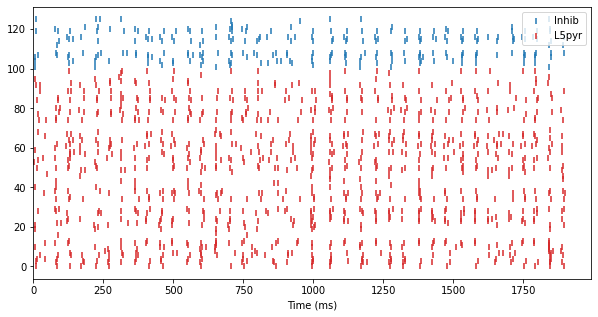

In [25]:
cell_spike_indices = np.where(cell_spikes > 0)
L5pyr_mask, inhib_mask = np.in1d(cell_spike_indices[1], L5pyr_gids), np.in1d(cell_spike_indices[1], inhib_gids)
L5pyr_spikes = (cell_spike_indices[1][L5pyr_mask], cell_spike_indices[0][L5pyr_mask])
inhib_spikes = (cell_spike_indices[1][inhib_mask], cell_spike_indices[0][inhib_mask])

plt.figure(figsize=(10, 5))
plt.scatter(inhib_spikes[1] * dt, inhib_spikes[0], c='C0', marker='|', label='Inhib')
plt.scatter(L5pyr_spikes[1] * dt, L5pyr_spikes[0], c='C3', marker='|', label='L5pyr')
plt.xlim(0, None)
plt.legend()
plt.xlabel('Time (ms)')

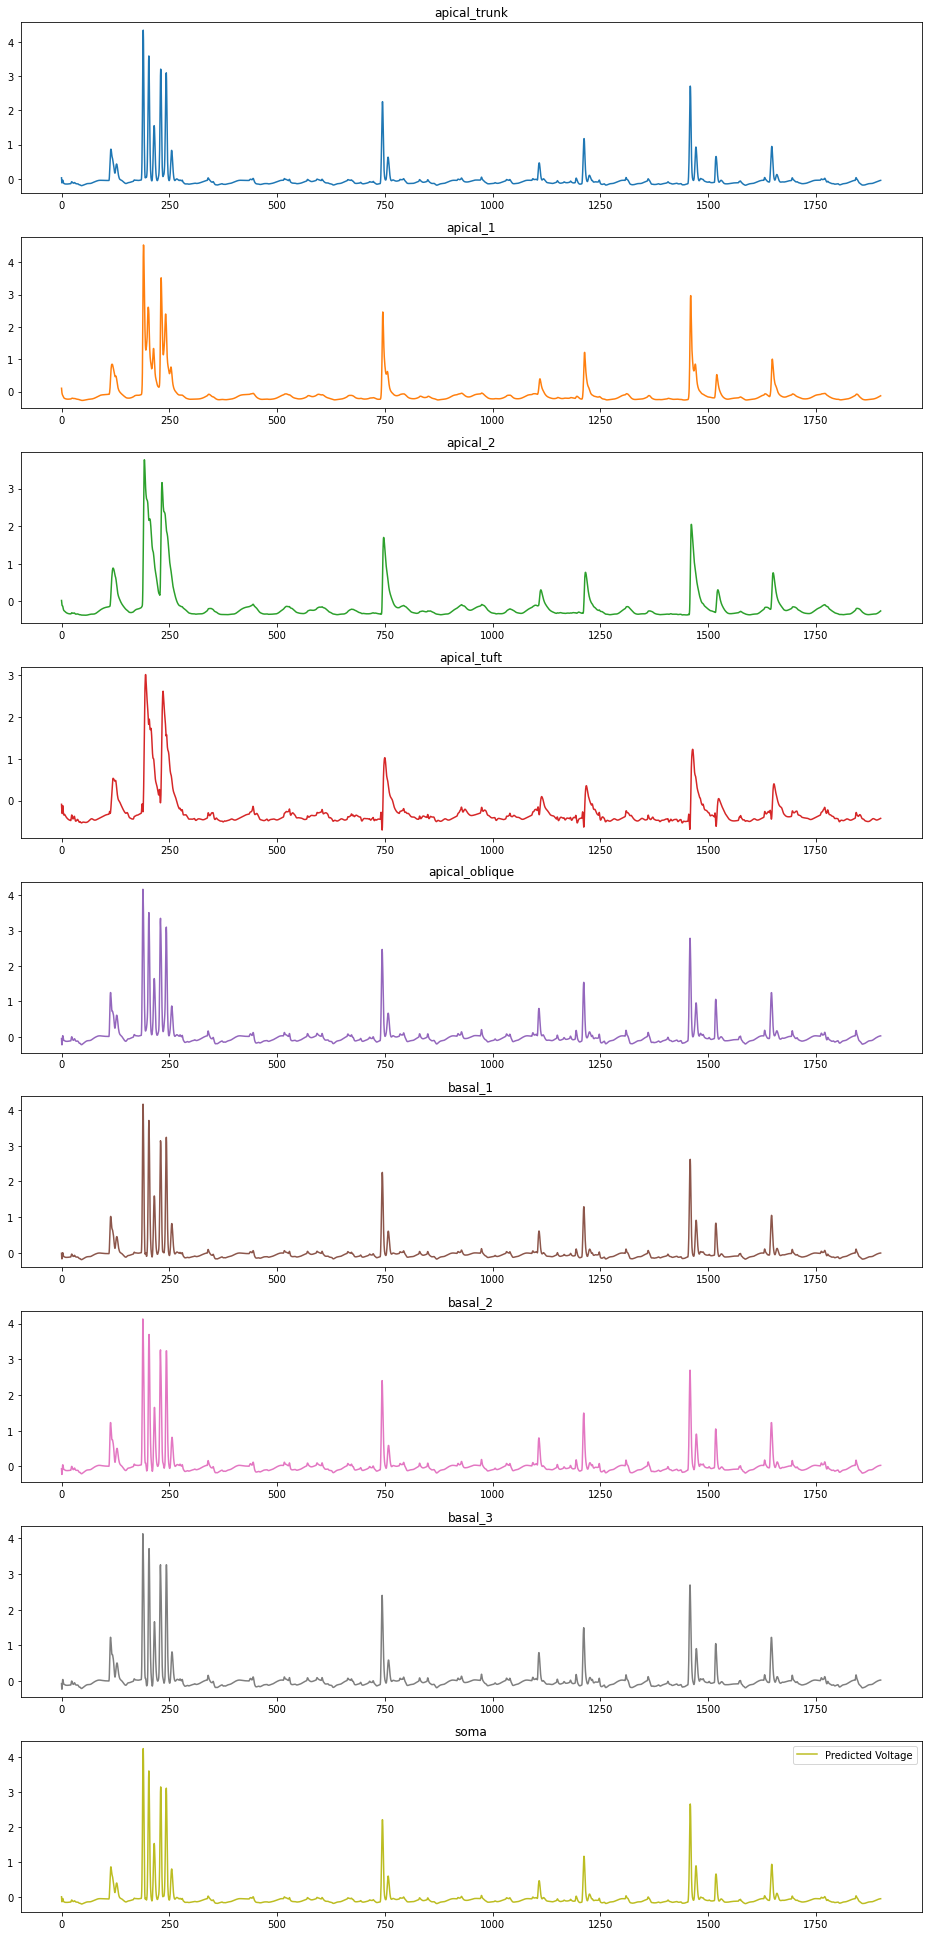

In [ ]:
output_size = len(training_set.vsec_names)
tvec = np.linspace(0, pred_y_np.shape[0] * dt, pred_y_np.shape[0])
plt.figure(figsize=(13, 3 * output_size))

for idx in range(output_size):
    plt.subplot(output_size, 1, idx+1)
    plt.plot(tvec, pred_y_np[:, 1, idx], color=f'C{idx}', label='Predicted Voltage')
    # plt.xlim(2000, 4000)
    plt.title(training_set.vsec_names[idx])
    # plt.ylim(-0.5,1.8)
plt.legend()
plt.tight_layout()

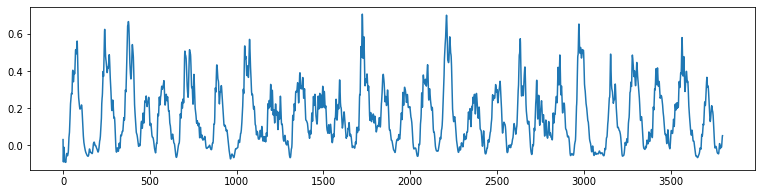

In [ ]:
plt.figure(figsize=(13, 3))
plt.plot(np.mean(pred_y_np[:, :,-1], axis=1))

In [12]:
# def random_weight_matrix(n_cells, n_sec, sec_indices, src_size=100, target_size=100,
#                          src_range=None, target_range=None, max_weight=10, weight_matrix=None):
#     if weight_matrix is None:
#         weight_matrix = torch.zeros((n_cells, n_sec, n_cells)).float()

    
#     if src_range is None:
#         src_range = list(range(n_cells))

#     if target_range is None:
#         target_range = list(range(n_cells))

#     src_gid_list = np.random.choice(src_range, size=src_size, replace=False)
#     for src_gid in src_gid_list:
#         target_gid_list = np.random.choice(target_range, size=target_size, replace=False)
#         for target_gid in target_gid_list:
#             # print(weight_matrix)
#             weight_matrix[target_gid, sec_indices, src_gid] += np.random.uniform(0,max_weight)
#     return weight_matrix

# weight_matrix = random_weight_matrix(n_cells=n_cells, n_sec=L5pyr_model.input_size, sec_indices=prox_indices,
#                                      src_size=n_L5Pyr, target_size=5, src_range=L5pyr_gids)
                                     
# weight_matrix = random_weight_matrix(n_cells=n_cells, n_sec=L5pyr_model.input_size, sec_indices=inhib_indices,
#                                      src_size=n_inhib, target_size=100, src_range=inhib_gids, weight_matrix=weight_matrix)